# Recurrent Neural Network

## (0) Libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

# Data Visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# System
import os

# Deep Learning
import tensorflow as tf

# Checking data types
from typing import Dict, List, Tuple, Sequence
import string

2022-12-02 14:12:14.078906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## (1) 📚 The dataset

### (1.1) Loading the dataset

💾 Load it.

In [2]:
df = pd.read_csv('../data/pollution/inputs/Xy_PA75016.csv',index_col='Date_time')
df = df.reset_index(drop=True)

In [3]:
df

,PM25,PM10,NO2,ATMO
0,0.000000,-0.001422,-0.732394,4
1,0.000000,-0.001422,-0.732394,4
2,0.000000,-0.001422,-0.732394,4
3,0.000000,-0.001422,-0.732394,4
4,0.000000,-0.025605,-0.510563,4
...,...,...,...,...
1770,-0.562911,-0.504979,-0.517606,4
1771,-0.633635,0.012802,-0.278169,4
1772,-1.473684,-0.315789,-0.880282,3
1773,-0.908306,1.544808,1.109155,3


In [4]:
df['ATMO'].value_counts()

4    899
5    721
3    150
2      4
1      1
Name: ATMO, dtype: int64

In [5]:
baseline = 899/1775
baseline

0.5064788732394366

👆 *(Reminders*) This weather dataset is a ***single Time Series*** represented as a DataFrame, i.e. a **2D-array**.
- `df.shape = (n_timesteps, n_features)`
    - `n_timesteps` $= 1775$k rows  (_~5 years of weather data, from 2018 to 2022 with 1 record every day (mean from hourly records_)
    - `n_features` $= 4$ features composed of:
        - $1$ <font color=green>**target**</font> (we will use the past values of the temperature as a feature)
        - $4$ <font color=orange>**past covariates**</font> (= features which past values are known)
        - $0$ <font color=blue>**future covariates**</font> (= features which future values are known, e.g. public holidays)
    
<img src='https://github.com/lewagon/data-images/blob/master/DL/time-series-covariates.png?raw=true'>    

### (1.2) 🌅 The big picture about dealing with Time Series *(reminder)*

1️⃣ <b>[FOLDS] <u>Cross-Validation in Time Series  </u></b>

Starting from this single Time Series:
- We will create <font color="#c91ac9">**FOLDS**</font>
- <font color=blue>**Train**</font>/<font color="#ff8005">**Evaluate**</font> our LSTM  <font color="#c91ac9">**on each of these different FOLDS**</font> to conclude about <b><u>the robustness of the model</u><b>.
    
_It is very common to create hundreds of folds in Time Series forecasting, in order to cover all types of external conditions: crash market periods, bull markets, atone markets, etc..._

2️⃣ <b>[TRAIN-TEST SPLIT] <u>Holdout method</u></b>

For each <font color="#c91ac9">**FOLD**</font>, we will do a <font color=blue>**TRAIN**</font>-<font color="#ff8005">**TEST**</font> SPLIT to:
* <font color=blue>**fit**</font> the model on the <font color=blue>**train**</font> set 
* <font color="#ff8005">**evaluate**</font> it on the <font color="#ff8005">**test**</font> set

_Always split the train set **chronologically** before the test set!_

<hr> 

👇 The first two steps can be summarized in the following image (here, we illustrated a 4-fold temporal cross-validation):

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/06-DL/time_series_cross_validation.png" alt="Time Series Cross Validation" width="800" height="400">

<hr>

3️⃣ <b>[SEQUENCES] <u>Sampling/Extracting sequences</u></b>


After splitting each fold into a <font color="blue">train</font> set and a <font color="#ff8005">test</font> set, it is time to:
- 🏋 sample lots of <font color="#884dff"><i>sequences</i></font> $\color{blue}{(X_i, y_i)}$ on which the model will be <font color="blue">trained</font>
- 👩🏻‍🏫 sample lots of <font color="#884dff"><i>sequences</i></font> $\color{#ff8005}{(X_i, y_i)}$ on which the model will be <font color="#ff8005">evaluated</font>


<img src="https://bit.ly/3Ri8Vfd" alt="Sequences in each fold" width="500" height="500"> 

👉 All these <font color="#884dff"><i>sequences</i></font> in the <font color="blue">train</font> set and the <font color="#ff8005">test</font> set will have a common shape `(input_length, n_features)` $ = (14\times8,19) = (112,19)$.

👉 Each <font color="#884dff"><i>sequence</i></font> has a target, the shape of which will be `(output_length, n_targets)` $ = (7\times8, 1) = (56, 1)$.

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/06-DL/shapes_for_input_sequence_and_ouput_sequence.png" alt="3d arrays time series" width="1200" height="800"> 

<hr>

> 🔥 Open this [**infograph**](https://wagon-public-datasets.s3.amazonaws.com/data-science-images/06-DL/big_picture_temporal_data_handling.png)  side-by-side with the notebook for a visual summary! 🔥

## (2) Adapting the functions from the _"Predict Temperature"_ challenge

### (2.0) Global Variables

🌐 Let's define some ***global variables*** that we will use for our tests everywhere in this notebook:

In [6]:
# Folds
FOLD_LENGTH = 228      # dont 365J Train +  156J Test
FOLD_STRIDE = int(91) # sliding each semester - décalage de 209J pour obtenir 7 folds

# Temporal Train-Test split
TRAIN_TEST_RATIO = 0.7 #70% de train et 30% de test par fold
#N_TRAIN = 365 # number_of_sequences_train for each fold_train
#N_TEST = 156 # number_of_sequences_test for each fold_test

# Inputs
N_FEATURES = 4  # 3 polluants + l'ATMO index
INPUT_LENGTH = 7 # - Records 1 week ~ 7 days. One week is quite common for air quality  

# Outputs
TARGET = ['ATMO']
TARGET_COLUMN_IDX = 3 # Corresponds to the third column of the df
N_TARGETS = 1
OUTPUT_LENGTH = N_TARGETS*7 # Predicting one target, the ATMO index for 7 days
                              

# Additional parameters
HORIZON = 1 # - You want to predict this point HORIZON = 1 day after the last known value

### (2.1)  🗂 <font color="#c91ac9">FOLDS</font>

🎁 **`get_folds`**

In [7]:
def get_folds(df: pd.DataFrame, 
              fold_length: int,
              fold_stride: int) -> List[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''

    folds = []
    for idx in range(0, len(df), fold_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]
        folds.append(fold)
    return folds

👉 Let's generate these <font color="#c91ac9">**FOLDS**</font>.

In [8]:
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')
print(f'The last fold has a shape equal to {folds[-1].shape}.')
np.array(folds).shape

The function generated 18 folds.
Each fold has a shape equal to (228, 4).
The last fold has a shape equal to (228, 4).


(18, 228, 4)

7 Folds

521 Observations (fold_length)

4 features (3 pollutants + 1 target )

🧪 Make sure that the following <font color=green>***assert***</font> doesn't return anything (which means the assertion is correct).

In [9]:
#assert(folds[0].shape == (180, 4))

☝️ This amount of <font color="#c91ac9">**FOLDS**</font> should be enough to cross-validate our model correctly!

### (2.2) ✂️  Temporal <font color=blue>Train</font>/<font color="#ff8005">Test</font> Split

👩🏻‍🏫 Let's <font color="#c91ac9">focus on one fold</font> for the moment, the first one for example.

In [10]:
fold = folds[-1]
fold

,PM25,PM10,NO2,ATMO
1547,-0.539474,0.770982,0.799296,4
1548,-0.807566,-0.310100,-0.890845,4
1549,-0.668586,-0.231863,-0.193662,4
1550,-0.383224,-0.143670,0.080986,4
1551,0.364309,0.274538,0.193662,5
...,...,...,...,...
1770,-0.562911,-0.504979,-0.517606,4
1771,-0.633635,0.012802,-0.278169,4
1772,-1.473684,-0.315789,-0.880282,3
1773,-0.908306,1.544808,1.109155,3


⌚️ We want to ***split this <font color="#c91ac9">fold</font> chronologically*** into a <font color=blue>***fold_train***</font> and a <font color="#ff8005">***fold_test***</font>.

*Each of these fold_train and fold_test will contain all the data we need to be able to sample many pairs `(Xi, yi)` in a next step!*

#### (2.2.1) 🧑🏻‍🏫 The complexity introduced by the <font color=green>gap</font>

<details>
    <summary>⏸ Let's take a <i>quick break</i> from this weather dataset to understand what is a temporal gap.</summary>

<hr>

🤑 Put yourself in the shoes of a quantitative trader at timesteps $\color{blue}{1}, \color{blue}{2}, \color{blue}{3}, ..., \color{blue}{10}$.

Let's say you are in the <font color=blue>training</font> phase, and you want to stop your training after day `10`:
- You have to wait until day `10` to know the real value $y_{10}$, and compare it with the predicted value $\hat{y}_{10}$ to train the model.
 
Here are the <font color=blue>assumptions about your model</font>:
- It is trained on <font color="#884dff"><i>sequences</i></font> with `INPUT_LENGTH = 3`
- The goal is to predict `OUTPUT_LENGTH = 1` point in the future
- You want to predict this point `HORIZON = 4` days after the last known value.

✅ Imagine that your model was trained and put into production

❓ <u>On which day can you evaluate the live performance of the model for the first time</u> ❓

* You are at day `10`. Hence, the first prediction you can make is for day `10` + `HORIZON` = `14`
* You will have to wait until day `14` to see how good was your prediction!
    * `y_test_first` = day `14`
* You sit IDLE for <font color=green>3</font> days $(11, 12, 13)$
    
</details>    

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/06-DL/train_test_split_with_horizon.jpg?raw=true" height=500 width=800>

👉 The <font color=green>gap</font> between the <font color=blue>train</font> and the <font color=orange>test</font> set should be equal to `GAP = HORIZON - 1`.

#### (2.2.2) 💻 Adapting the  `train_test_split` function accordingly

💻 ❓ **Question ❓ (Temporal <font color=blue>Train</font>/<font color=orange>Test</font> split)** 

Code the function `train_test_split` down below which:
- <i>(inputs)</i> given 
    - a `fold` (like above), 
    - a `train_test_ratio` (e.g 0.8) 
    - an `input_length` (fixed)
    - 🆕 a `horizon` (fixed)
- <i>(output)</i> returns a tuple (`fold_train`, `fold_test`) of DataFrames

In [11]:
def train_test_split(fold: pd.DataFrame, 
                     train_test_ratio: float,
                     input_length: int, 
                     horizon: int) -> Tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    # $CHALLENGIFY_BEGIN

    # TRAIN SET
    # ======================
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    # ======================
    first_test_idx = last_train_idx - input_length
    fold_test = fold.iloc[first_test_idx:, :]

    return (fold_train, fold_test)

    # $CHALLENGIFY_END

💻 ❓ **Question ❓ (Temporal <font color=blue>Train</font>/<font color=orange>Test</font> split for <font color="#c91ac9">one fold </font>)** 

Split the <font color="#c91ac9">fold #0</font>.


<details>
    <summary><i>Reminders</i></summary>

*As a reminder, in  section `(2.0) Global Variables`, we defined*:
- *`TRAIN_TEST_RATIO` = 66%* 
- *`INPUT_LENGTH` = 2 weeks = 112 time steps for each `Xi`, which is quite common in weather forecasting*
- *`HORIZON` = 1 day = 8 time steps*

</details>


In [12]:
(fold_train, fold_test) = train_test_split(fold, 
                                           TRAIN_TEST_RATIO,
                                           INPUT_LENGTH, 
                                           HORIZON)

In [13]:
fold_train.shape, fold_test.shape

((160, 4), (75, 4))

🧪 Check that your shapes and your starting/ending points are correct:

In [14]:
fold_train.index.start

1547

In [15]:
## Double-checking the shapes for the fold_train and fold_test
fold_train.shape == (120, 4)
fold_test.shape == (61, 4)

## Double-checking the starting point and the ending point for both folds
# assert (fold_train.index.start) == 0
# assert (fold_train.index.stop) == 126
# assert (fold_test.index.start) == 119 # 365 - 7 Jours prédiction sur 7 jours soit les 7 derniers jours non utilisés dans le training 
# assert (fold_test.index.stop) == 180

False

### (2.3) 💻 🔢 Create (X, y) sequences

In [16]:
# Inputs
print("##### INPUTS #####")
print(f'- INPUT_LENGTH = {INPUT_LENGTH} timesteps = {int(INPUT_LENGTH)} days = {int(INPUT_LENGTH/7)} week')
print(f'- N_FEATURES = {N_FEATURES}')
# Outputs
print("##### OUTPUTS #####")
print(f'- OUTPUT_LENGTH = {OUTPUT_LENGTH} timesteps = {int(OUTPUT_LENGTH)} day(s)')
print(f'- N_TARGETS = {N_TARGETS}')
# Parameters
print("##### PARAMETERS #####")
print(f'- HORIZON = {HORIZON} timesteps = {int(HORIZON)} day(s)')
# Train
print("##### TRAIN SET #####")
print(f"- The training fold starts at index {fold_train.index.start} and stops at index {fold_train.index.stop}.")
# Test
print("##### TEST SET #####")
print(f"- The test fold starts at index {fold_test.index.start} and stops at index {fold_test.index.stop}.")

##### INPUTS #####
- INPUT_LENGTH = 7 timesteps = 7 days = 1 week
- N_FEATURES = 4
##### OUTPUTS #####
- OUTPUT_LENGTH = 7 timesteps = 7 day(s)
- N_TARGETS = 1
##### PARAMETERS #####
- HORIZON = 1 timesteps = 1 day(s)
##### TRAIN SET #####
- The training fold starts at index 1547 and stops at index 1707.
##### TEST SET #####
- The test fold starts at index 1700 and stops at index 1775.


In [17]:
# New: Scanning  through a fold  
STRIDE = 1 # sliding every  days, for subfolds
print(f'STRIDE = {STRIDE} timesteps = {int(STRIDE)} day()')

STRIDE = 1 timesteps = 1 day()


💻 ❓ **Question ❓ (Extracting a <font color="#884dff"><i>sequence</i></font>)** 

Code the function `get_Xi_yi` which extracts a <font color="#884dff"><i>sequence</i></font> from a Time Series: it should take the following arguments:
- `first_index`
- `data` (your 2D-dataframe representing the Time Series)
- `input_length`
- `output_length`
- `horizon`

In [18]:
def get_Xi_yi(first_index: int, 
              fold: pd.DataFrame, 
              horizon: int,
              input_length: int,
              output_length: int) -> Tuple[np.ndarray, np.ndarray]:
    '''
    - extracts one sub-fold from a fold
    - returns a pair (Xi, yi) with:
        * len(Xi) = `input_length` and Xi starting at first_index
        * len(yi) = `output_length`
        * last_Xi and first_yi separated by the gap = horizon -1
    '''

    # $CHALLENGIFY_BEGIN

    Xi_start = first_index
    Xi_last = Xi_start + input_length
    yi_start = Xi_last + horizon - 1
    yi_last = yi_start + output_length

    Xi = fold[Xi_start:Xi_last]
    yi = fold[yi_start:yi_last][TARGET]

    return (Xi, yi)

    # $CHALLENGIFY_END

🧪 Run the following cell to test your function:

In [19]:
## Testing your function get_Xi_yi

first_index = fold.index.start
Xi, yi = get_Xi_yi(first_index=first_index,
                   fold=fold,
                   horizon=HORIZON,
                   input_length=INPUT_LENGTH,
                   output_length=OUTPUT_LENGTH)

# assert (Xi.index.start == first_index)
# assert (Xi.shape == (INPUT_LENGTH, 4))
# assert (yi.index.stop == Xi.index.stop + HORIZON - 1 + OUTPUT_LENGTH)
# assert (yi.shape == (OUTPUT_LENGTH, 1))

💻 ❓ **Question ❓ (Creating <font color="#884dff"><i>sequences</i></font>, scanning chronologically through a fold)** 

Code the function `get_X_y` to scan an entire fold and extract sequences.

In [20]:
def get_X_y(fold: pd.DataFrame,
            horizon: int,
            input_length: int,
            output_length: int,
            stride: int,
            shuffle=True) -> Tuple[np.ndarray, np.ndarray]:
    """
    - Uses `data`, a 2D-array with axis=0 for timesteps, and axis=1 for (targets+covariates columns)
    - Returns a Tuple (X,y) of two ndarrays :
        * X.shape = (n_samples, input_length, n_covariates)
        * y.shape =
            (n_samples, output_length, n_targets) if all 3-dimensions are of size > 1
            (n_samples, output_length) if n_targets == 1
            (n_samples, n_targets) if output_length == 1
            (n_samples, ) if both n_targets and lenghts == 1
    - You can shuffle the pairs (Xi,yi) of your fold
    """

    # $CHALLENGIFY_BEGIN
    X = []
    y = []

    # Scanning the fold/data entirely with a certain stride
    for i in range(0, len(fold), stride):
        ## Extracting a sequence starting at index_i
        Xi, yi = get_Xi_yi(first_index=i,
                           fold=fold,
                           horizon=horizon,
                           input_length=input_length,
                           output_length=output_length)
        ## Exits loop as soon as we reach the end of the dataset
        if len(yi) < output_length:
            break
        X.append(Xi)
        y.append(yi)

    X = np.array(X)
    y = np.array(y)
    y = np.squeeze(y)

    if shuffle:
        idx = np.arange(len(X))
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

    return X, y

    # $CHALLENGIFY_END

💻 ❓ **Question ❓ Generate <font color="#884dff"><i>sequences</i></font>** both in the <font color=blue>**train**</font> set and the <font color="#ff8005">**test**</font> set.

In [21]:
X_train, y_train = get_X_y(fold=fold_train,
                           horizon=HORIZON,
                           input_length=INPUT_LENGTH,
                           output_length=OUTPUT_LENGTH,
                           stride=STRIDE)
X_test, y_test = get_X_y(fold=fold_test,
                         horizon=HORIZON,
                         input_length=INPUT_LENGTH,
                         output_length=OUTPUT_LENGTH,
                         stride=STRIDE)

print("Shapes for the training set:")
print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")

print("Shapes for the test set:")
print(f"X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

Shapes for the training set:
X_train.shape = (147, 7, 4), y_train.shape = (147, 7)
Shapes for the test set:
X_test.shape = (62, 7, 4), y_test.shape = (62, 7)


> For X_train, the base is 365 days. Subfolds have a length of 7 days. The 1st subfold xi is the 1st 7 days, and the 1st yi is the 8th to 14th days = 7 days.
There are 358 days left for other subfolds (because the 1st subfold xi takes 7 days), but as y has a length of 7 days, there are 351 days left to subfold for xi.
--> 1 subfold + 351 next subfolds.

> For X_test, the base is 163 days (156 days + 7 last days of X_train). Subfolds have a length of 7 days. The 1st subfold xi is the 1st 7 days, and the 1st yi is the 8th to 14th days = 7 days.
There are 156 days left for other subfolds (because the 1st subfold xi takes 7 days), but as y has a length of 7 days, there are 149 days left to subfold for xi.
--> 1 subfold + 150 next subfolds.

🧪 Test that your shapes are correct. If not, go back to the function to debug it.

In [22]:
X_train.shape, INPUT_LENGTH, N_FEATURES

((147, 7, 4), 7, 4)

In [23]:
y_train.shape

(147, 7)

In [24]:
X_test.shape

(62, 7, 4)

In [25]:
y_test.shape

(62, 7)

In [26]:
## ASSERTS
# assert(X_train.shape == (113, INPUT_LENGTH, N_FEATURES))
# assert(y_train.shape == (113, OUTPUT_LENGTH))
# assert(X_test.shape == (48, INPUT_LENGTH, N_FEATURES))
# assert(y_test.shape == (48, OUTPUT_LENGTH))

## (3) 💻 Modelling

### (3.1) 💻 LSTM

In [27]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import regularizers

In [28]:
X_train.shape

(147, 7, 4)

In [29]:
X_test.shape

(62, 7, 4)

In [30]:
y_train.shape

(147, 7)

In [31]:
y_test.shape

(62, 7)

In [32]:
def init_model(X_train, y_train):

     # 1 - RNN architecture
    # ======================    
    model = models.Sequential()  
    
    # Recurrent Layer
    model.add(layers.LSTM(units=80, activation='relu',input_shape=X_train[0].shape ,return_sequences=True))
    
    # Recurrent Layer
    model.add(layers.LSTM(units=60, activation='relu',return_sequences=True))
    
    # Recurrent Layer
    model.add(layers.LSTM(units=40, activation='relu',return_sequences=True))
    
    # Recurrent Layer
    model.add(layers.LSTM(units=20, activation='relu',return_sequences=True))

    # Predictive Dense Layer 
    model.add(layers.Dense(6, activation='softmax'))
    
    # 2 - Compiler
    # ======================
    initial_learning_rate = 0.001
    lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.0001)

    #Le sparse_categorical_crossentrop permet de ne pas avoir à faire un OneHotEncoding de la target en 6 catégories
    adam = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=["accuracy"])

    return model
    

In [33]:
# Test grid search
# KO - A retester

# import tensorflow as tf
# from tensorboard.plugins.hparams import api as hp

# HP_NUM_UNITS = hp.HParam('units', hp.Discrete([20, 40, 60, 80, 100]))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.0, 0.2))
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'rmsprop']))

# METRIC_ACCURACY = 'accuracy'

# with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
#     hp.hparams_config(
#         hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, HP_EPOCHS],
#         metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
#     )

# def init_model2(X_train, y_train, hparams):

#      # 1 - RNN architecture
#     # ======================    
#     model = models.Sequential()  
    
# #    normalizer = Normalization()
# #    normalizer.adapt(X_train)
    
#     # Recurrent Layer
#     model.add(layers.LSTM(hparams[HP_NUM_UNITS], activation='relu',input_shape=X_train[0].shape ,return_sequences=True))
    
#     # Recurrent Layer
#     model.add(layers.LSTM(hparams[HP_NUM_UNITS], activation='relu',return_sequences=True))
    
#     # Recurrent Layer
#     model.add(layers.LSTM(hparams[HP_NUM_UNITS], activation='relu',return_sequences=True))
#     model.add(layers.Dropout(hparams[HP_DROPOUT]))
    
#     # Recurrent Layer
#     model.add(layers.LSTM(hparams[HP_NUM_UNITS], activation='relu',return_sequences=True))
#     model.add(layers.Dropout(hparams[HP_DROPOUT]))

#     # Predictive Dense Layer 
#     model.add(layers.Dense(6, activation='softmax'))
    
    
#     # 2 - Compiler
#     # ======================
#     #initial_learning_rate = 0.001
#     #lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.0001)

#     #Le sparse_categorical_crossentrop permet de ne pas avoir à faire un OneHotEncoding de la target en 6 catégories
#     #adam = optimizers.Adam(learning_rate=lr_schedule)
#     model.compile(loss='sparse_categorical_crossentropy', optimizer=hparams[HP_OPTIMIZER], metrics=["accuracy"])

#     return model

In [34]:
model = init_model(X_train, y_train)

2022-12-02 14:12:18.226871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 80)             27200     
                                                                 
 lstm_1 (LSTM)               (None, 7, 60)             33840     
                                                                 
 lstm_2 (LSTM)               (None, 7, 40)             16160     
                                                                 
 lstm_3 (LSTM)               (None, 7, 20)             4880      
                                                                 
 dense (Dense)               (None, 7, 6)              126       
                                                                 
Total params: 82,206
Trainable params: 82,206
Non-trainable params: 0
_________________________________________________________________


🎁 **Training**: We can re-use the function `fit_model` from the last challenge to <font color=blue>train</font> the model.

In [36]:
from tensorflow.keras.callbacks import EarlyStopping


def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor="val_loss",
                       patience=5,
                       mode="min",
                       restore_best_weights=True)

    history = model.fit(X_train,
                        y_train,
                        validation_split=0.3,
                        shuffle=False,
                        batch_size=32,
                        epochs=80,
                        callbacks=[es],
                        verbose=verbose)

    return model, history

🎁 **Visualizing performance:** Feel free to use the `plot_history` function to visualize how your model learned.

In [37]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: Sparse_categorical_crossentropy --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS: accuracy ---
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('accuracy')
    ax[1].set_ylabel('accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

💻 ❓ **Questions ❓ (Training and Evaluating the LSTM model)**

Using your functions `init_model` and `fit_model`:
1. **Initialize** your model
2. <font color=blue>**Train**</font> it and observe the performances on the train set and the validation set
3. <font color=orange>**Evaluate**</font> it on the test set

_Feel free to apply regularization techniques in the architecture if the model overfits._

Epoch 1/80
4/4 [==============================] - 6s 276ms/step - loss: 1.7834 - accuracy: 0.4454 - val_loss: 1.7668 - val_accuracy: 0.6381
Epoch 2/80
4/4 [==============================] - 0s 28ms/step - loss: 1.7604 - accuracy: 0.6527 - val_loss: 1.7379 - val_accuracy: 0.6381
Epoch 3/80
4/4 [==============================] - 0s 23ms/step - loss: 1.7289 - accuracy: 0.6527 - val_loss: 1.6920 - val_accuracy: 0.6381
Epoch 4/80
4/4 [==============================] - 0s 29ms/step - loss: 1.6770 - accuracy: 0.6527 - val_loss: 1.6033 - val_accuracy: 0.6381
Epoch 5/80
4/4 [==============================] - 0s 24ms/step - loss: 1.5809 - accuracy: 0.6527 - val_loss: 1.4527 - val_accuracy: 0.6381
Epoch 6/80
4/4 [==============================] - 0s 28ms/step - loss: 1.5262 - accuracy: 0.6527 - val_loss: 1.4043 - val_accuracy: 0.6381
Epoch 7/80
4/4 [==============================] - 0s 24ms/step - loss: 1.4493 - accuracy: 0.6527 - val_loss: 1.3687 - val_accuracy: 0.6381
Epoch 8/80
4/4 [==========

4/4 [==============================] - 0s 24ms/step - loss: 0.9101 - accuracy: 0.6541 - val_loss: 0.9156 - val_accuracy: 0.6349
Epoch 60/80
4/4 [==============================] - 0s 29ms/step - loss: 0.9085 - accuracy: 0.6541 - val_loss: 0.9152 - val_accuracy: 0.6349
Epoch 61/80
4/4 [==============================] - 0s 23ms/step - loss: 0.9071 - accuracy: 0.6527 - val_loss: 0.9147 - val_accuracy: 0.6349
Epoch 62/80
4/4 [==============================] - 0s 22ms/step - loss: 0.9057 - accuracy: 0.6527 - val_loss: 0.9142 - val_accuracy: 0.6349
Epoch 63/80
4/4 [==============================] - 0s 21ms/step - loss: 0.9043 - accuracy: 0.6527 - val_loss: 0.9138 - val_accuracy: 0.6349
Epoch 64/80
4/4 [==============================] - 0s 24ms/step - loss: 0.9031 - accuracy: 0.6527 - val_loss: 0.9133 - val_accuracy: 0.6349
Epoch 65/80
4/4 [==============================] - 0s 27ms/step - loss: 0.9018 - accuracy: 0.6527 - val_loss: 0.9128 - val_accuracy: 0.6349
Epoch 66/80
4/4 [===============

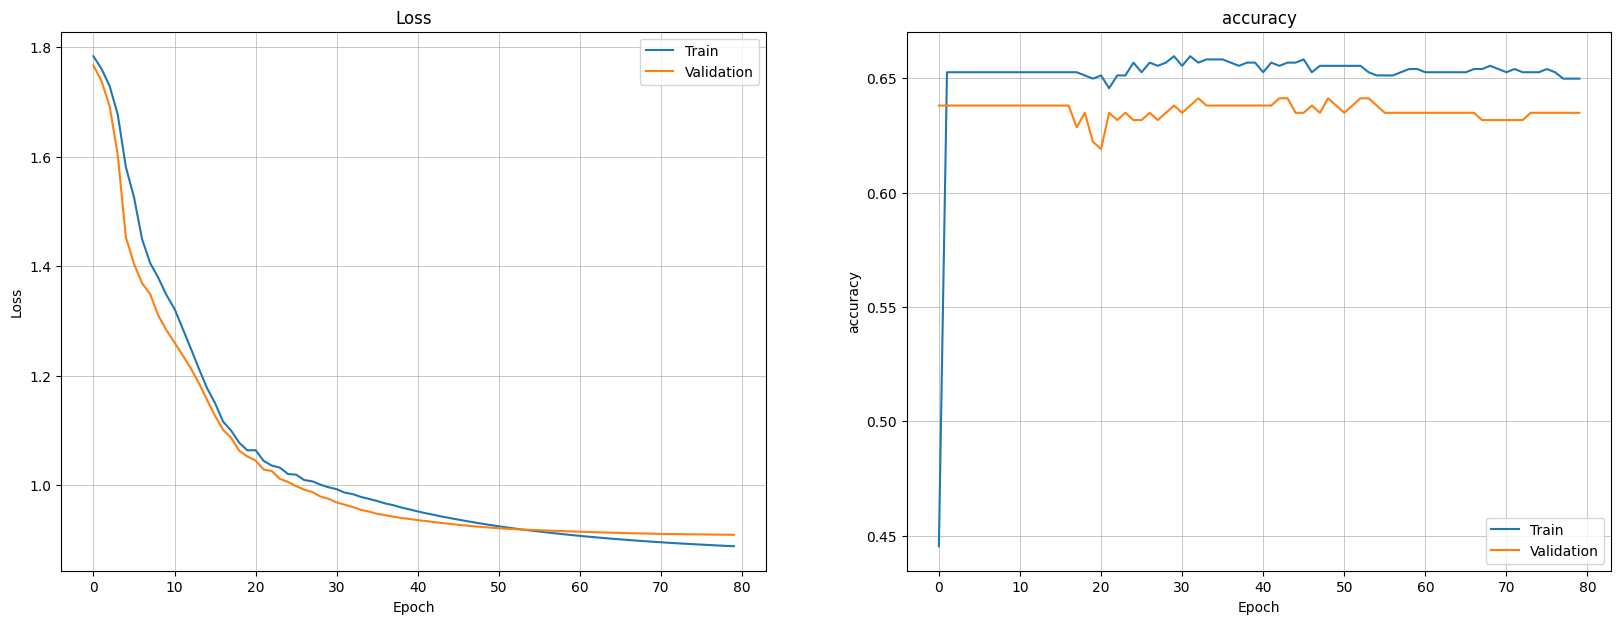

In [38]:
%%time
# 1 - Initialising the RNN model
# ==================================== #
model = init_model(X_train, y_train)
#model.summary()

# 2 - Training
# ====================================
model, history = fit_model(model, verbose=1)
plot_history(history);

# 3 - Evaluation
# ====================================
res = model.evaluate(X_test, y_test)
print("-"*50)
print(f"The LSTM accuracy on the test set is equal to {round(res[1],2)}, (meaning the model is guessing the correct predictions {round(res[1]*100,2)}% of the time).")

In [39]:
model.predict(X_test).shape

2/2 [==============================] - 1s 7ms/step


(62, 7, 6)

In [40]:
np.round(model.predict(X_test)[0],2)

2/2 [==============================] - 0s 6ms/step


array([[0.15, 0.13, 0.13, 0.16, 0.22, 0.2 ],
       [0.08, 0.05, 0.04, 0.1 , 0.45, 0.28],
       [0.  , 0.  , 0.  , 0.03, 0.71, 0.26],
       [0.  , 0.  , 0.  , 0.04, 0.63, 0.34],
       [0.  , 0.  , 0.  , 0.01, 0.34, 0.66],
       [0.  , 0.  , 0.  , 0.06, 0.5 , 0.44],
       [0.  , 0.  , 0.  , 0.04, 0.45, 0.52]], dtype=float32)

### (3.2) 🎁 Baseline with a horizon

👉 (*Reminder*) ***In Time Series, an "intuitive" baseline model is to repeat the last seen value as (a) prediction(s) for the future value(s)*** you want to forecast, as illustrated down below!

<img src = "https://github.com/davydw/public-pictures/blob/main/last_seen_value_with_horizon.png?raw=true" width = 600 height = 300>

🎁 **The Last Seen Value Baseline Model** 

Let's go together through the function `baseline` which:
- (_input_) takes a pair $(X, y)$ 
- (_output_) computes the accuracy of the baseline model

In [41]:
# from sklearn.metrics import accuracy_score # import library

# def baseline(df):
#     df['ATMO_baseline'] = df['ATMO'].shift(periods=8,axis=0) #creation of y_pred by shifting target of 7 days
#     y_baseline = df['ATMO_baseline'][8:] #take off the 7 first values to drop nan
#     y_true = df['ATMO'][8:] #take off the 7 first values to drop nan
#     accuracy = accuracy_score(y_true, y_baseline) # use accuracy modul from sklearn
#     df = df.drop(columns=['ATMO_baseline'])

#     return accuracy

🕵🏻‍♀️ What is the performance of the "last seen value baseline model" on the <font color=orange>**test**</font> set?

In [42]:
# 1 - Evaluation of the baseline model
# ====================================
#accuracy_baseline = baseline(df)
accuracy_baseline = 0.54

print(f"- The baseline accuracy on the test set is equal to {round(accuracy_baseline,2)}")

# 4 - Comparison with the LSTM model
# ====================================
print(f"- The LSTM accuracy on the test set is equal to {round(res[1],2)}, (meaning the model is guessing the correct predictions {round(res[1]*100,2)}% of the time).")
print(f"👉 Improvement/decrease of the LSTM model over the baseline (on this fold for the test set) = : {round(((res[1]-accuracy_baseline)/accuracy_baseline)*100,2)} % 👈")

- The baseline accuracy on the test set is equal to 0.54
- The LSTM accuracy on the test set is equal to 0.51, (meaning the model is guessing the correct predictions 50.92% of the time).
👉 Improvement/decrease of the LSTM model over the baseline (on this fold for the test set) = : -5.7 % 👈


In [43]:
df

,PM25,PM10,NO2,ATMO
0,0.000000,-0.001422,-0.732394,4
1,0.000000,-0.001422,-0.732394,4
2,0.000000,-0.001422,-0.732394,4
3,0.000000,-0.001422,-0.732394,4
4,0.000000,-0.025605,-0.510563,4
...,...,...,...,...
1770,-0.562911,-0.504979,-0.517606,4
1771,-0.633635,0.012802,-0.278169,4
1772,-1.473684,-0.315789,-0.880282,3
1773,-0.908306,1.544808,1.109155,3


<u><b><i>Warnings:</i></b></u>

* <font color=red>***The more data points in the future we try to predict, the lower your accuracy will be!***</font>

### (3.3) 💻 Cross-Validation

ℹ️ Reminders of the global variables in this notebook:

In [44]:
# Folds
print('##### FOLDS ##### ')
print(f'- FOLD_LENGTH = {FOLD_LENGTH} timesteps = {1} year x {365} days x {1} record per day + 156 days of test')
print(f'- FOLD_STRIDE = {FOLD_STRIDE} timesteps = {(365/4)} days x {1} record per day(s) = sliding each trimester')

# Chronological Train Test Split
print('##### TRAIN TEST SPLIT #####')
print(f'- TRAIN_TEST_RATIO = {TRAIN_TEST_RATIO}')
#print(f'- N_TRAIN = {N_TRAIN}')
#print(f'- N_TEST = {N_TEST}')

# Inputs
print('##### INPUTS #####')
print(f'- INPUT_LENGTH = {INPUT_LENGTH} timesteps = {int(INPUT_LENGTH)} days x {1} record(s) per day = {int(INPUT_LENGTH/7)} week(s)')
print(f'- N_FEATURES = {N_FEATURES}') 

# Outputs
print('##### OUTPUTS #####')
print(f'- OUTPUT_LENGTH = {OUTPUT_LENGTH} timesteps = {int(OUTPUT_LENGTH)} day(s) x {1} record(s) per day')
print(f"- Trying to predict:{TARGET}")
print(f'- N_TARGETS = {N_TARGETS}') 

# Parameters
print('##### PARAMETERS #####')
print(f'- HORIZON = {HORIZON} timesteps = {int(HORIZON)} day(s) x {8} record(s) per day')


##### FOLDS ##### 
- FOLD_LENGTH = 228 timesteps = 1 year x 365 days x 1 record per day + 156 days of test
- FOLD_STRIDE = 91 timesteps = 91.25 days x 1 record per day(s) = sliding each trimester
##### TRAIN TEST SPLIT #####
- TRAIN_TEST_RATIO = 0.7
##### INPUTS #####
- INPUT_LENGTH = 7 timesteps = 7 days x 1 record(s) per day = 1 week(s)
- N_FEATURES = 4
##### OUTPUTS #####
- OUTPUT_LENGTH = 7 timesteps = 7 day(s) x 1 record(s) per day
- Trying to predict:['ATMO']
- N_TARGETS = 1
##### PARAMETERS #####
- HORIZON = 1 timesteps = 1 day(s) x 8 record(s) per day


In [45]:
# Remember how many folds do we have ?
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)
print(f"WARNING, we have {len(folds)} FOLDS, it may take a long time to run...!")

WARNING, we have 18 FOLDS, it may take a long time to run...!


🎁 **Cross-validating the LSTM and the baseline** 

_Let's go together through the following code_ 👇

In [46]:
list_of_accuracy_baseline_model = []
list_of_accuracy_recurrent_model = []
    
# 1 - Creating FOLDS
# =======================================================
    
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)
    
for fold_id, fold in enumerate(folds):    
    
    # 2 - CHRONOLOGICAL TRAIN TEST SPLIT of the current FOLD
    # =======================================================    
    
    (fold_train, fold_test) = train_test_split(fold = fold, 
                                               train_test_ratio = TRAIN_TEST_RATIO, 
                                               input_length = INPUT_LENGTH, 
                                               horizon = HORIZON) 
    
    # 3 - Scanninng fold_train and fold_test for SEQUENCES 
    # =======================================================       
    
    X_train, y_train = get_X_y(fold = fold_train, 
                               horizon = HORIZON, 
                               input_length = INPUT_LENGTH, 
                               output_length = OUTPUT_LENGTH, 
                               stride = STRIDE)
    
    X_test, y_test = get_X_y(fold_test, 
                             horizon = HORIZON, 
                             input_length = INPUT_LENGTH, 
                             output_length = OUTPUT_LENGTH,
                             stride = STRIDE)
    
    # 4.1 - Baseline Model
    # =======================================================
#    accuracy_baseline = baseline(df)
    
    accuracy_baseline = 0.54
    
    list_of_accuracy_baseline_model.append(accuracy_baseline)
    
    print("-"*50)
    print(f"Accuracy baseline fold n°{fold_id} = {round(accuracy_baseline, 2)}")        
    
    
    # 4.2 - LSTM Model
    # =======================================================
    
    # Initializing the LSTM Model
    model = init_model(X_train, y_train)
    
    # Training
    model, history = fit_model(model, verbose=0)
    
    # Evaluation
    res = model.evaluate(X_test, y_test, verbose = 0)
    accuracy_lstm = res[1]
    
    list_of_accuracy_recurrent_model.append(accuracy_lstm)
    
    print(f"Accuracy LSTM fold n°{fold_id} = {round(accuracy_lstm, 2)}")
    
    # 4.3 - Comparison LSTM vs Baseline for the current fold
    # =======================================================
    print(f"🏋🏽‍♂️ Improvement/Decrease vs. Baseline: {round(((accuracy_lstm-accuracy_baseline)/accuracy_baseline)*100,2)} % \n")

--------------------------------------------------
Accuracy baseline fold n°0 = 0.54
Accuracy LSTM fold n°0 = 0.76
🏋🏽‍♂️ Improvement/Decrease vs. Baseline: 40.38 % 

--------------------------------------------------
Accuracy baseline fold n°1 = 0.54
Accuracy LSTM fold n°1 = 0.58
🏋🏽‍♂️ Improvement/Decrease vs. Baseline: 7.53 % 

--------------------------------------------------
Accuracy baseline fold n°2 = 0.54
Accuracy LSTM fold n°2 = 0.58
🏋🏽‍♂️ Improvement/Decrease vs. Baseline: 6.67 % 

--------------------------------------------------
Accuracy baseline fold n°3 = 0.54
Accuracy LSTM fold n°3 = 0.77
🏋🏽‍♂️ Improvement/Decrease vs. Baseline: 42.09 % 

--------------------------------------------------
Accuracy baseline fold n°4 = 0.54
Accuracy LSTM fold n°4 = 0.53
🏋🏽‍♂️ Improvement/Decrease vs. Baseline: -2.71 % 

--------------------------------------------------
Accuracy baseline fold n°5 = 0.54
Accuracy LSTM fold n°5 = 0.29
🏋🏽‍♂️ Improvement/Decrease vs. Baseline: -45.38 % 

-----

In [47]:
list_of_accuracy_recurrent_model

[0.7580645084381104,
 0.5806451439857483,
 0.5760368704795837,
 0.7672811150550842,
 0.5253456234931946,
 0.2949308753013611,
 0.6751152276992798,
 0.4354838728904724,
 0.48156681656837463,
 0.6244239807128906,
 0.804147481918335,
 0.5,
 0.6520737409591675,
 0.5276497602462769,
 0.6359447240829468,
 0.6036866307258606,
 0.5944700241088867,
 0.48156681656837463]

In [48]:
cv_accuracy_baseline = np.mean(list_of_accuracy_baseline_model)
cv_accuracy_lstm = np.mean(list_of_accuracy_recurrent_model)

print("-"*50)
print(f"Average accuracy baseline = {round(cv_accuracy_baseline, 2)}")    
print(f"Average accuracy LSTM = {round(cv_accuracy_lstm, 2)}")    
print(f"🏋🏽‍♂️ Improvement/Decrease vs. Baseline: {round(((cv_accuracy_lstm-cv_accuracy_baseline)/cv_accuracy_baseline)*100,2)} % \n")

--------------------------------------------------
Average accuracy baseline = 0.54
Average accuracy LSTM = 0.58
🏋🏽‍♂️ Improvement/Decrease vs. Baseline: 8.21 % 

